from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls

%cd drive/Shared\ drives/repo/TensorFlow-2.x-YOLOv3/
!ls

!python train.py

In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from yolov3.yolov3 import Create_Yolov3
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

input_size = YOLO_INPUT_SIZE
Darknet_weights = YOLO_DARKNET_WEIGHTS

#yolo = Create_Yolov3(input_size=input_size)
#load_yolo_weights(yolo, Darknet_weights) # use Darknet weight


In [2]:
import colorsys
import random

In [19]:
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes


def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)


def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)

    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]
        # Process 1: Determine whether the number of bounding boxes is greater than 0 
        while len(cls_bboxes) > 0:
            # Process 2: Select the bounding box with the highest score according to socre order A
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            # Process 3: Calculate this bounding box A and
            # Remain all iou of the bounding box and remove those bounding boxes whose iou value is higher than the threshold 
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes


def draw_bbox(image, bboxes, CLASSES=YOLO_COCO_CLASSES, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors=''):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != ''else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000) / 15
        if bbox_thick < 1: bbox_thick = 1
        #print(image_h, image_w, bbox_thick)
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            #score_str = f' {score:.2f}' if show_confidence else ''
            score_str = " {:.2f}".format(score) if show_confidence else "" 
            #label = f'{NUM_CLASS[class_ind]}' + score_str
            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image



def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names


In [20]:
def detect_(yolo, image_path = "./star/0.jpg", score_th=0.5, iou_th=0.45):

    original_image      = cv2.imread(image_path)
    #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    #original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = tf.expand_dims(image_data, 0)
    
    pred_bbox = yolo.predict(image_data)
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
        
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold=score_th)
    bboxes = nms(bboxes, iou_threshold=iou_th, method='nms')
    
    image = draw_bbox(original_image, bboxes, CLASSES=TRAIN_CLASSES, 
                      Text_colors=(255,0,0),
                      rectangle_colors=(128,255,0))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    return bboxes

In [5]:
#yolo = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)
#yolo.load_weights("./checkpoints/yolov3_star") # use weights at epoch 60


In [12]:
yolo_ = Create_Yolov3(input_size=input_size, CLASSES=TRAIN_CLASSES)
yolo_.load_weights("./checkpoints/LE800/yolov3_LE800") # use weights at epoch 60


In [50]:
np.stack(bboxes, axis=0)[:, 5]

array([0., 1., 1., 1., 1., 1., 1.])

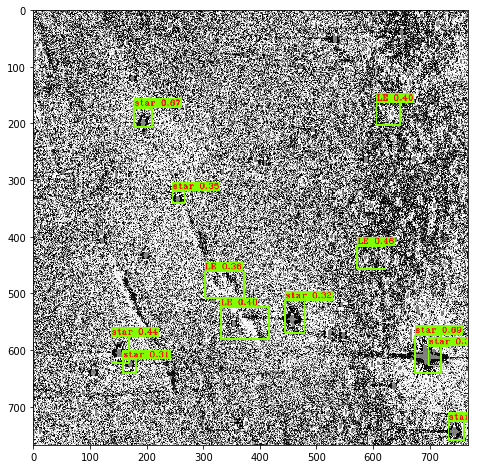

In [56]:
bboxes = detect_(yolo_, image_path='dataset/LEs/LEs_test/test2017/47_r90.jpg', score_th=0.29, iou_th=0.45);


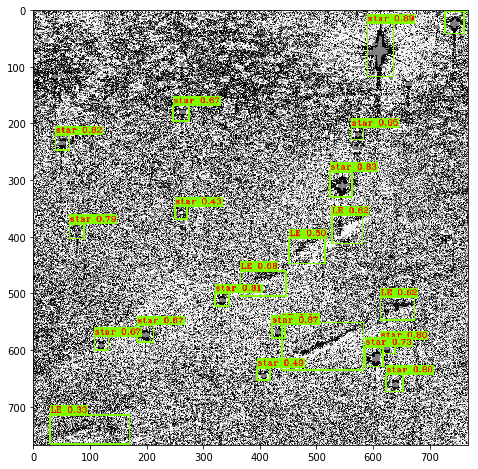

In [54]:
bboxes = detect_(yolo_, image_path='dataset/LEs/LEs_test/test2017/47.jpg', score_th=0.29, iou_th=0.45);


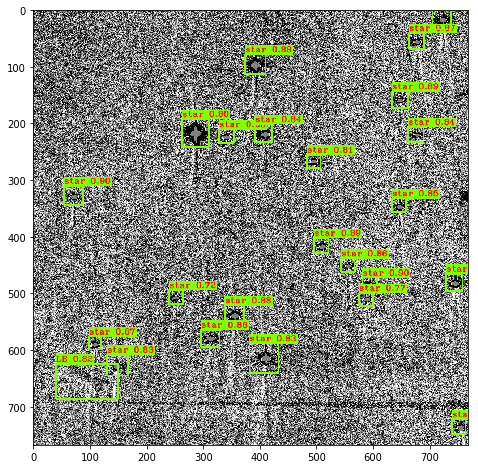

In [45]:
bboxes = detect_(yolo_, image_path='dataset/LEs/LEs_test/train2017/170.jpg', score_th=0.29, iou_th=0.45);


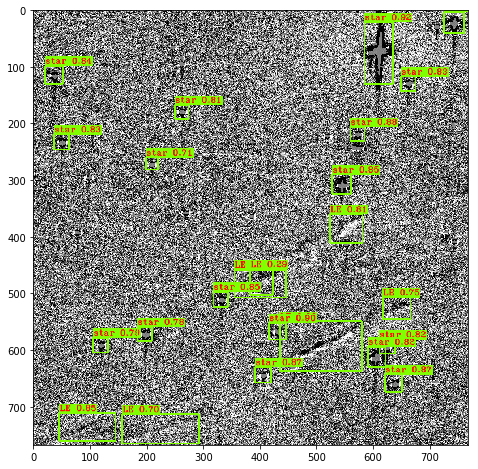

In [40]:
bboxes = detect_(yolo_, image_path='dataset/LEs/LEs_test/6.jpg', score_th=0.29, iou_th=0.45);


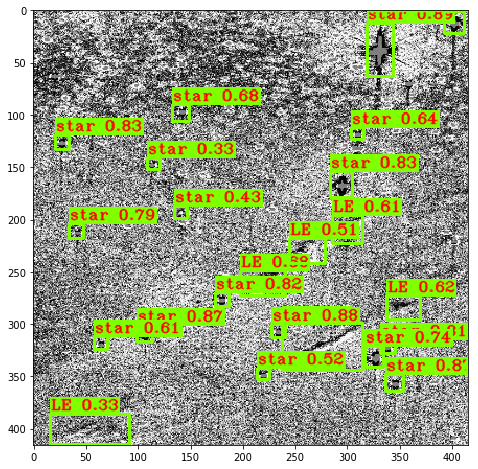

In [29]:
bboxes = detect_(yolo_, image_path='dataset/LEs/LEs_test/000003.jpg', score_th=0.29, iou_th=0.45);


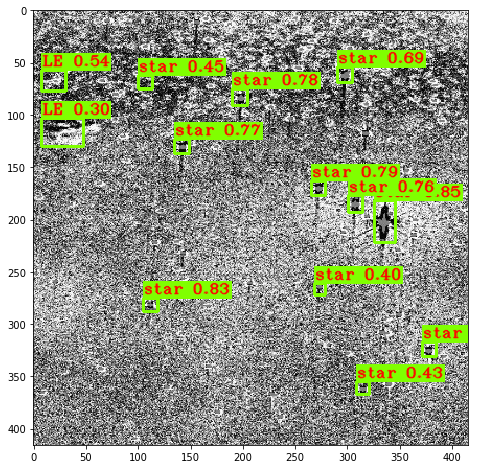

In [27]:
detect_(yolo_, image_path='dataset/LEs/LEs_test/000007.jpg', score_th=0.29, iou_th=0.45);


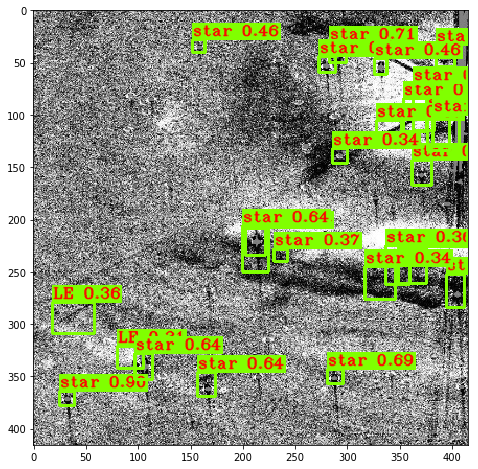

In [23]:
detect_(yolo_, image_path='dataset/LEs/LEs_test/000006.jpg', score_th=0.3, iou_th=0.45);

In [93]:
import pandas as pd

In [120]:
loss = pd.read_csv('./star/yolo_loss.csv', sep=',' )


In [121]:
loss.columns

Index(['epoch', 'total_loss', 'total_val_loss'], dtype='object')

Text(0, 0.5, 'loss')

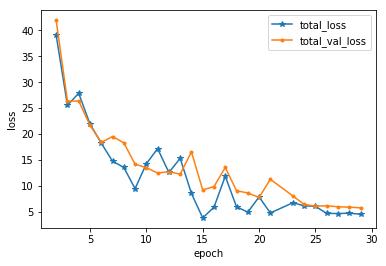

In [132]:
plt.plot(loss.epoch[2:], loss.total_loss[2:], '*-', label='total_loss', )
plt.plot(loss.epoch[2:], loss.total_val_loss[2:],'.-', label='total_val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')